In [5]:
from google.colab import files


uploaded = files.upload()

Saving SPY_data.csv to SPY_data.csv


In [6]:
import pandas as pd
import numpy as np

# Sample CSV data format: Assuming the CSV has 'Date', 'Close', 'High', 'Low', 'Volume'

data = pd.read_csv('SPY_data.csv', parse_dates=['Date'], index_col='Date')

# Convert the data to a DataFrame
df = pd.DataFrame(data)

In [ ]:
# 1. RSI Calculation
def calculate_rsi(df, periods=14):
    # Calculate price differences (delta)
    delta = df['Close'].diff()

    # Initialize arrays to store gains and losses
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta < 0, -delta, 0)

    # Initialize the RSI column with NaN
    df['RSI'] = np.nan

    # Loop to calculate RSI values for each row starting from the 'periods' row
    for i in range(periods, len(df)):
        avg_gain = np.mean(gain[i-periods+1:i+1])
        avg_loss = np.mean(loss[i-periods+1:i+1])

        # Avoid division by zero
        if avg_loss == 0:
            rs = np.nan
        else:
            rs = avg_gain / avg_loss

        rsi = 100 - (100 / (1 + rs)) if rs == rs else np.nan  # Use 'rs == rs' to check for NaN

        df.at[df.index[i], 'RSI'] = rsi  # Assign RSI value to the DataFrame

    return df

In [ ]:
# 2. ADX Calculation
def calculate_adx(df, periods=14):
    plus_dm = df['High'].diff()
    minus_dm = df['Low'].diff()

    plus_dm[plus_dm < 0] = 0
    minus_dm[minus_dm > 0] = 0

    atr = (df['High'] - df['Low']).rolling(window=periods).mean()

    plus_di = 100 * (plus_dm.rolling(window=periods).mean() / atr)
    minus_di = abs(100 * (minus_dm.rolling(window=periods).mean() / atr))

    dx = (abs(plus_di - minus_di) / abs(plus_di + minus_di)) * 100
    adx = dx.rolling(window=periods).mean()
    df['ADX'] = adx
    return df



In [102]:
# 3. CCI Calculation
def calculate_cci(df, periods=20):
    # Check if necessary columns exist in the DataFrame
    if not all(col in df.columns for col in ['High', 'Low', 'Close']):
        print("Error: Missing one or more required columns ('High', 'Low', 'Close') in DataFrame.")
        return df  # Return the original DataFrame unmodified if columns are missing

    # Calculate Typical Price (TP)
    tp = (df['High'] + df['Low'] + df['Close']) / 3

    # Calculate Simple Moving Average (SMA) of Typical Price
    sma = tp.rolling(window=periods).mean()

    # Calculate Mean Absolute Deviation (MAD)
    mad = tp.rolling(window=periods).apply(lambda x: np.fabs(x - x.mean()).mean())

    # Calculate CCI
    cci = (tp - sma) / (0.015 * mad)

    # Add the CCI to the DataFrame
    df['CCI'] = cci

    return df

b = calculate_cci(df, periods=20)
b

Open        High         Low       Close   Adj Close  \
Date                                                                     
1993-01-29   43.968750   43.968750   43.750000   43.937500   24.684103   
1993-02-01   43.968750   44.250000   43.968750   44.250000   24.859661   
1993-02-02   44.218750   44.375000   44.125000   44.343750   24.912321   
1993-02-03   44.406250   44.843750   44.375000   44.812500   25.175669   
1993-02-04   44.968750   45.093750   44.468750   45.000000   25.281023   
...                ...         ...         ...         ...         ...   
2024-08-15  549.500000  553.359985  548.880005  553.070007  553.070007   
2024-08-16  551.419983  555.020020  551.260010  554.309998  554.309998   
2024-08-19  554.729980  559.609985  553.859985  559.609985  559.609985   
2024-08-20  559.150024  560.840027  557.330017  558.700012  558.700012   
2024-08-21  559.770020  562.109985  554.729980  560.619995  560.619995   

              Volume        RSI        ADX         CCI      MACD  Signal_Line  \
Date                                                                            
1993-01-29   1003200        NaN        NaN         NaN  0.000000     0.000000   
1993-02-01    480500        NaN        NaN         NaN  0.024929     0.004986   
1993-02-02    201300        NaN        NaN         NaN  0.051654     0.014319   
1993-02-03    529400        NaN        NaN         NaN  0.109398     0.033335   
1993-02-04    531500        NaN        NaN         NaN  0.168349     0.060338   
...              ...        ...        ...         ...       ...          ...   
2024-08-15  60846800  54.903963  47.692606   89.554066 -1.600329    -3.214515   
2024-08-16  44430700  55.370587  44.375383  100.243626 -0.267531    -2.625118   
2024-08-19  39121800  59.628196  40.020454  127.462453  1.202523    -1.859590   
2024-08-20  33732300  54.721729  36.724586  132.621765  2.267981    -1.034076   
2024-08-21  41467000  61.336407  33.443972  120.392326  3.230056    -0.181249   

             Momentum  RSI_Signal  Price_Change  Predicted_Signal  
Date                                                               
1993-01-29        NaN           0      0.007112                 1  
1993-02-01        NaN           0      0.002119                 1  
1993-02-02        NaN           0      0.010571                 1  
1993-02-03        NaN           0      0.004184                 1  
1993-02-04        NaN           0     -0.000694                 0  
...               ...         ...           ...               ...  
2024-08-15   8.630005           0      0.002242                 0  
2024-08-16   9.549988           0      0.009561                 0  
2024-08-19  17.609985           0     -0.001626                 0  
2024-08-20   7.890014           0      0.003437                 0  
2024-08-21  17.609985           0           NaN                 1  

[7947 rows x 15 columns]

In [9]:
# 4. MACD Calculation
def calculate_macd(df, short_period=12, long_period=26, signal_period=9):
    short_ema = df['Close'].ewm(span=short_period, adjust=False).mean()
    long_ema = df['Close'].ewm(span=long_period, adjust=False).mean()
    macd = short_ema - long_ema
    signal = macd.ewm(span=signal_period, adjust=False).mean()
    df['MACD'] = macd
    df['Signal_Line'] = signal
    return df


In [ ]:
# 5. Momentum Calculation
def calculate_momentum(df, periods=14):
    momentum = df['Close'].diff(periods=periods)
    df['Momentum'] = momentum
    return df


In [116]:
from datetime import datetime

def difference_in_years(start_date, end_date):
    # Calculate the difference in days
    difference_in_days = (end_date - start_date).days

    # Convert days to years
    difference_in_years = difference_in_days / 365.25  # Accounts for leap years

    return difference_in_years


In [106]:
# Backtesting RSI strategy
def backtest_rsi(df, rsi_period=14, lower_threshold=30, upper_threshold=70):
    # Select only the columns needed for the calculations
    df_relevant = df[['Close']].copy()

    # Calculate RSI
    df_relevant = calculate_rsi(df_relevant, periods=rsi_period)

    # Create signals
    df_relevant['Buy_Signal'] = np.where(df_relevant['RSI'] < lower_threshold, 1, 0)  # Buy signal when RSI < 30
    df_relevant['Sell_Signal'] = np.where(df_relevant['RSI'] > upper_threshold, -1, 0)  # Sell signal when RSI > 70

    # Add columns to hold positions and returns
    df_relevant['Position'] = 0
    df_relevant['Returns'] = 0.0

    # Initial capital
    initial_capital = 10000  # $10,000 starting capital
    position = 0  # No position at the start
    capital = initial_capital

    for i in range(1, len(df_relevant)):
        if df_relevant['Buy_Signal'].iloc[i] == 1 and position == 0:
            position = capital / df_relevant['Close'].iloc[i]  # Buy stock with available capital
            df_relevant['Position'].iloc[i] = position
            capital = 0
        elif df_relevant['Sell_Signal'].iloc[i] == -1 and position > 0:
            capital = position * df_relevant['Close'].iloc[i]  # Sell stock
            position = 0
            df_relevant['Position'].iloc[i] = 0

        df_relevant['Returns'].iloc[i] = (position * df_relevant['Close'].iloc[i]) + capital  # Calculate returns

    return df_relevant

# Backtesting results
rsi_backtest_results = backtest_rsi(df, rsi_period=13, lower_threshold=32.7743057901687, upper_threshold=98.27663744224036) #Best Parameters: {'rsi_period': 30, 'lower_threshold': 39.90760190634312, 'upper_threshold': 77.95994450797626}
#Best Score: 97095.24819516658
#rsi_backtest_results = backtest_rsi(df, rsi_period=2, lower_threshold=20, upper_threshold=79.118989)

#Best Parameters: {'rsi_period': 13, 'lower_threshold': 32.7743057901687, 'upper_threshold': 98.27663744224036}
#Best Score: 132983.54802892287

# Analyze the results
final_capital = rsi_backtest_results['Returns'].iloc[-1]
print(f"Final Capital After Backtest: ${final_capital:.2f}")

# Display the final few rows
rsi_backtest_results[['Close', 'RSI', 'Buy_Signal', 'Sell_Signal', 'Position', 'Returns']]

Streaming output truncated to the last 5000 lines.
<ipython-input-106-510d9ac1d51a>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_relevant['Returns'].iloc[i] = (position * df_relevant['Close'].iloc[i]) + capital  # Calculate returns
<ipython-input-106-510d9ac1d51a>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_relevant['Returns'].iloc[i] = (position * df_relevant['Close'].iloc[i]) + capital  # Calculate returns
<ipython-input-106-510d9ac1d51a>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pand

Final Capital After Backtest: $132983.55


<ipython-input-106-510d9ac1d51a>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_relevant['Returns'].iloc[i] = (position * df_relevant['Close'].iloc[i]) + capital  # Calculate returns
<ipython-input-106-510d9ac1d51a>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_relevant['Returns'].iloc[i] = (position * df_relevant['Close'].iloc[i]) + capital  # Calculate returns
<ipython-input-106-510d9ac1d51a>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

Close        RSI  Buy_Signal  Sell_Signal  Position  \
Date                                                                   
1993-01-29   43.937500        NaN           0            0       0.0   
1993-02-01   44.250000        NaN           0            0       0.0   
1993-02-02   44.343750        NaN           0            0       0.0   
1993-02-03   44.812500        NaN           0            0       0.0   
1993-02-04   45.000000        NaN           0            0       0.0   
...                ...        ...         ...          ...       ...   
2024-08-15  553.070007  54.739356           0            0       0.0   
2024-08-16  554.309998  57.144507           0            0       0.0   
2024-08-19  559.609985  55.324285           0            0       0.0   
2024-08-20  558.700012  60.356429           0            0       0.0   
2024-08-21  560.619995  70.515059           0            0       0.0   

                  Returns  
Date                       
1993-01-29       0.000000  
1993-02-01   10000.000000  
1993-02-02   10000.000000  
1993-02-03   10000.000000  
1993-02-04   10000.000000  
...                   ...  
2024-08-15  131192.630472  
2024-08-16  131486.766258  
2024-08-19  132743.965576  
2024-08-20  132528.112701  
2024-08-21  132983.548029  

[7947 rows x 6 columns]

2024-08-21 00:00:00 1993-02-23 00:00:00
t: 31.49075975359343
Buy & Hold Returns: 11.589361291228071
Annualized Buy & Hold Returns:0.08091010921655739
Buy & Hold Vol: 0.011782446969985897
Annualized Buy & Hold Vol: 0.06611911974569874
Buy & Hold Sharpe Ratio: 0.6792302950990048

RSI Returns: 12.298354802892288
Annualized RSI Returns:0.08295016081590734
RSI Vol: 0.011756847131258885
Annualized RSI Vol: 0.06597546208217828
RSI Sharpe Ratio: 0.7116306477312241


<Axes: xlabel='Date'>

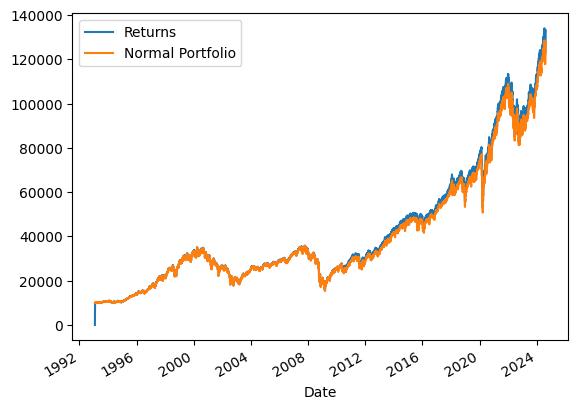

In [180]:
#Calculate normal returns and RSI returns
end_date = (rsi_backtest_results.index[-1])
start_date = (rsi_backtest_results[rsi_backtest_results['Buy_Signal'] == 1].index[0])
print(end_date, start_date)
t = difference_in_years(start_date, end_date)
print(f"t: {t}")
rf = 0.036

returns_normal = rsi_backtest_results['Close'].iloc[-1] / rsi_backtest_results['Close'].loc['1993-04-20'] - 1
print(f"Buy & Hold Returns: {returns_normal}")
normal_annualized_returns = returns_normal ** (1/t) - 1
print(f"Annualized Buy & Hold Returns:{normal_annualized_returns}")
normal_vol = rsi_backtest_results['Close'].pct_change().std()
print(f"Buy & Hold Vol: {normal_vol}")
annualized_normal_vol = normal_vol * (t ** (1/2))
print(f"Annualized Buy & Hold Vol: {annualized_normal_vol}")
normal_sharpe = ((normal_annualized_returns) - rf)/annualized_normal_vol
print(f"Buy & Hold Sharpe Ratio: {normal_sharpe}")

print()

rsi_returns = rsi_backtest_results['Returns'].iloc[-1] / rsi_backtest_results['Returns'].iloc[1] - 1
print(f"RSI Returns: {rsi_returns}")
annualized_rsi_returns = rsi_returns ** (1/t) - 1
print(f"Annualized RSI Returns:{annualized_rsi_returns}")
rsi_vol = rsi_backtest_results['Returns'].iloc[1:].pct_change().dropna().std()
print(f"RSI Vol: {rsi_vol}")
annualized_rsi_vol = rsi_vol * ((t) ** (1/2))
print(f"Annualized RSI Vol: {annualized_rsi_vol}")
rsi_sharpe = ((annualized_rsi_returns - rf))/annualized_rsi_vol
print(f"RSI Sharpe Ratio: {rsi_sharpe}")

rsi_backtest_results['Normal Position'] = 0
rsi_backtest_results['Normal Portfolio'] = 0
rsi_backtest_results['Normal Position'] = 10000/df['Close'].iloc[0]
rsi_backtest_results['Normal Portfolio'] = rsi_backtest_results['Normal Position'] *  df['Close']
rsi_backtest_results[['Returns', 'Normal Portfolio']].plot()


In [8]:
def backtest_macd(df, short_period=12, long_period=26, signal_period=9):
    df_relevant = df[['Close']].copy()

    # Calculate MACD
    df_relevant = calculate_macd(df_relevant, short_period, long_period, signal_period)

    # Create buy and sell signals
    df_relevant['Buy_Signal'] = np.where(df_relevant['MACD'] > df_relevant['Signal_Line'], 1, 0)  # Buy on bullish crossover
    df_relevant['Sell_Signal'] = np.where(df_relevant['MACD'] < df_relevant['Signal_Line'], -1, 0)  # Sell on bearish crossover

    # Initialize positions and returns
    df_relevant['Position'] = 0
    df_relevant['Returns'] = 0.0
    initial_capital = 10000
    position = 0
    capital = initial_capital

    for i in range(1, len(df_relevant)):
        if df_relevant['Buy_Signal'].iloc[i] == 1 and position == 0:
            position = capital / df_relevant['Close'].iloc[i]  # Buy
            df_relevant['Position'].iloc[i] = position
            capital = 0
        elif df_relevant['Sell_Signal'].iloc[i] == -1 and position > 0:
            capital = position * df_relevant['Close'].iloc[i]  # Sell
            position = 0
            df_relevant['Position'].iloc[i] = 0

        df_relevant['Returns'].iloc[i] = (position * df_relevant['Close'].iloc[i]) + capital  # Calculate returns

    return df_relevant

# 100 Trials
#Best MACD Parameters: {'short_period': 31, 'long_period': 179, 'signal_period': 6}
#Best MACD Score: 34688.872237147516

backtest_macd_df = backtest_macd(df, 31, 179, signal_period=6)
backtest_macd_df

Streaming output truncated to the last 5000 lines.
<ipython-input-12-39432a8e5128>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_relevant['Returns'].iloc[i] = (position * df_relevant['Close'].iloc[i]) + capital  # Calculate returns
<ipython-input-12-39432a8e5128>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_relevant['Returns'].iloc[i] = (position * df_relevant['Close'].iloc[i]) + capital  # Calculate returns
<ipython-input-12-39432a8e5128>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-

Close       MACD  Signal_Line  Buy_Signal  Sell_Signal  \
Date                                                                      
1993-01-29   43.937500   0.000000     0.000000           0            0   
1993-02-01   44.250000   0.016059     0.004588           1            0   
1993-02-02   44.343750   0.035754     0.013493           1            0   
1993-02-03   44.812500   0.078076     0.031945           1            0   
1993-02-04   45.000000   0.126893     0.059073           1            0   
...                ...        ...          ...         ...          ...   
2024-08-15  553.070007  28.467984    29.196327           0           -1   
2024-08-16  554.309998  28.841437    29.094930           0           -1   
2024-08-19  559.609985  29.439990    29.193518           1            0   
2024-08-20  558.700012  29.927692    29.403282           1            0   
2024-08-21  560.619995  30.457715    29.704549           1            0   

              Position       Returns  
Date                                  
1993-01-29    0.000000      0.000000  
1993-02-01  225.988701  10000.000000  
1993-02-02    0.000000  10021.186441  
1993-02-03    0.000000  10127.118644  
1993-02-04    0.000000  10169.491525  
...                ...           ...  
2024-08-15    0.000000  34626.376950  
2024-08-16    0.000000  34626.376950  
2024-08-19   61.875910  34626.376950  
2024-08-20    0.000000  34570.071542  
2024-08-21    0.000000  34688.872237  

[7947 rows x 7 columns]

2024-08-21 00:00:00 1993-02-01 00:00:00
t: 31.550992470910334
Buy & Hold Returns: 11.589361291228071
Annualized Buy & Hold Returns:0.08074957218755974
Buy & Hold Vol: 0.011782446969985897
Annualized Buy & Hold Vol: 0.06618232291608908
Buy & Hold Sharpe Ratio: 0.6761559615291323

MACD Returns: 2.4688872237147517
Annualized MACD Returns:0.029058866345927692
MACD Vol: 0.006578650582007026
Annualized MACD Vol: 0.03695245803181642
MACD Sharpe Ratio: -0.1878395653164919


<Axes: xlabel='Date'>

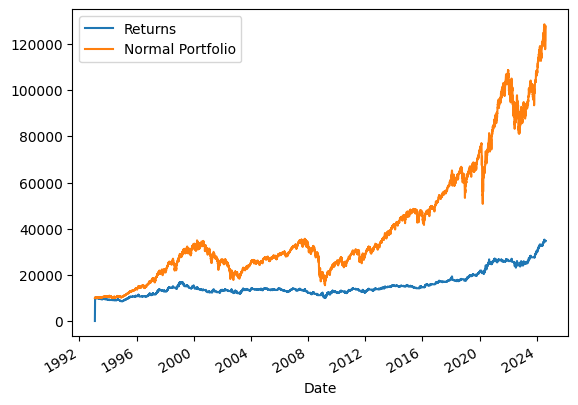

In [179]:
end_date = (backtest_macd_df.index[-1])
start_date = (backtest_macd_df[backtest_macd_df['Buy_Signal'] == 1].index[0])
print(end_date, start_date)
t = difference_in_years(start_date, end_date)
print(f"t: {t}")

rf = 0.036

returns_normal = backtest_macd_df['Close'].iloc[-1] / backtest_macd_df['Close'].loc['1993-04-20'] - 1
print(f"Buy & Hold Returns: {returns_normal}")
normal_annualized_returns = returns_normal ** (1/t) - 1
print(f"Annualized Buy & Hold Returns:{normal_annualized_returns}")
normal_vol = backtest_macd_df['Close'].pct_change().std()
print(f"Buy & Hold Vol: {normal_vol}")
annualized_normal_vol = normal_vol * (t ** (1/2))
print(f"Annualized Buy & Hold Vol: {annualized_normal_vol}")
normal_sharpe = ((normal_annualized_returns) - rf)/annualized_normal_vol
print(f"Buy & Hold Sharpe Ratio: {normal_sharpe}")

print()

macd_returns = backtest_macd_df['Returns'].iloc[-1] / backtest_macd_df['Returns'].iloc[1] - 1
print(f"MACD Returns: {macd_returns}")
annualized_macd_returns = macd_returns ** (1/t) - 1
print(f"Annualized MACD Returns:{annualized_macd_returns}")
macd_vol = backtest_macd_df['Returns'].iloc[1:].pct_change().dropna().std()
print(f"MACD Vol: {macd_vol}")
annualized_macd_vol = macd_vol * ((t) ** (1/2))
print(f"Annualized MACD Vol: {annualized_macd_vol}")
macd_sharpe = ((annualized_macd_returns - rf))/annualized_macd_vol
print(f"MACD Sharpe Ratio: {macd_sharpe}")

backtest_macd_df['Normal Position'] = 0
backtest_macd_df['Normal Portfolio'] = 0
backtest_macd_df['Normal Position'] = 10000/df['Close'].iloc[0]
backtest_macd_df['Normal Portfolio'] = backtest_macd_df['Normal Position'] *  df['Close']
backtest_macd_df[['Returns', 'Normal Portfolio']].plot()

In [169]:
def backtest_cci(df, cci_period=20, lower_threshold=-100, upper_threshold=100):
    # Select only the columns needed for the calculations and make a copy
    df_relevant = df[['Close', 'High', 'Low']].copy()

    # Calculate CCI on the df_relevant DataFrame
    df_relevant = calculate_cci(df_relevant, periods=cci_period)

    # Create signals based on CCI values
    df_relevant['Buy_Signal'] = np.where(df_relevant['CCI'] < lower_threshold, 1, 0)  # Buy signal when CCI < lower threshold (-100)
    df_relevant['Sell_Signal'] = np.where(df_relevant['CCI'] > upper_threshold, -1, 0)  # Sell signal when CCI > upper threshold (100)

    # Add columns to hold positions and returns
    df_relevant['Position'] = 0
    df_relevant['Returns'] = 0.0

    # Initial capital
    initial_capital = 10000  # $10,000 starting capital
    position = 0  # No position at the start
    capital = initial_capital

    for i in range(1, len(df_relevant)):
        if df_relevant['Buy_Signal'].iloc[i] == 1 and position == 0:
            position = capital / df_relevant['Close'].iloc[i]  # Buy stock with available capital
            df_relevant['Position'].iloc[i] = position
            capital = 0
        elif df_relevant['Sell_Signal'].iloc[i] == -1 and position > 0:
            capital = position * df_relevant['Close'].iloc[i]  # Sell stock
            position = 0
            df_relevant['Position'].iloc[i] = 0

        # Calculate returns based on current capital and position held
        df_relevant['Returns'].iloc[i] = (position * df_relevant['Close'].iloc[i]) + capital

    return df_relevant

# 100 trials
#Best CCI Parameters: {'cci_period': 10, 'overbought': 130.08471034934834, 'oversold': -110.75620776268163}
#Best CCI Score: 177077.6273972904

#backtest_cci_df = backtest_cci(df, 10, -110.75620776268163, 130.08471034934834)
backtest_cci_df = backtest_cci(df, 10, 130.08471034934834, -110.75620776268163)
backtest_cci_df


Streaming output truncated to the last 5000 lines.
<ipython-input-169-4336550f162c>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_relevant['Returns'].iloc[i] = (position * df_relevant['Close'].iloc[i]) + capital
<ipython-input-169-4336550f162c>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_relevant['Returns'].iloc[i] = (position * df_relevant['Close'].iloc[i]) + capital
<ipython-input-169-4336550f162c>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#re

Close        High         Low         CCI  Buy_Signal  \
Date                                                                     
1993-01-29   43.937500   43.968750   43.750000         NaN           0   
1993-02-01   44.250000   44.250000   43.968750         NaN           0   
1993-02-02   44.343750   44.375000   44.125000         NaN           0   
1993-02-03   44.812500   44.843750   44.375000         NaN           0   
1993-02-04   45.000000   45.093750   44.468750         NaN           0   
...                ...         ...         ...         ...         ...   
2024-08-15  553.070007  553.359985  548.880005  165.436067           0   
2024-08-16  554.309998  555.020020  551.260010  125.686750           1   
2024-08-19  559.609985  559.609985  553.859985  119.488274           1   
2024-08-20  558.700012  560.840027  557.330017  103.342732           1   
2024-08-21  560.619995  562.109985  554.729980   85.340642           1   

            Sell_Signal    Position        Returns  
Date                                                
1993-01-29            0    0.000000       0.000000  
1993-02-01            0    0.000000   10000.000000  
1993-02-02            0    0.000000   10000.000000  
1993-02-03            0    0.000000   10000.000000  
1993-02-04            0    0.000000   10000.000000  
...                 ...         ...            ...  
2024-08-15           -1    0.000000  174799.847308  
2024-08-16           -1  315.346734  174799.847308  
2024-08-19           -1    0.000000  176471.180896  
2024-08-20           -1  315.860349  176471.180896  
2024-08-21           -1    0.000000  177077.627397  

[7947 rows x 8 columns]

In [177]:
end_date = backtest_cci_df.index[-1]
start_date = (backtest_cci_df[backtest_cci_df['Buy_Signal'] == 1].index[0])
print(end_date, start_date)
t = difference_in_years(start_date, end_date)
print(f"t: {t}")

2024-08-21 00:00:00 1993-02-11 00:00:00
t: 31.523613963039015


Buy & Hold Returns: 11.589361291228071
Annualized Buy & Hold Returns:0.08082246455747555
Buy & Hold Vol: 0.011782446969985897
Annualized Buy & Hold Vol: 0.06615360168793614
Buy & Hold Sharpe Ratio: 0.6775513866790632

CCI Returns: 16.70776273972904
Annualized CCI Returns:0.09343688893082192
CCI Vol: 0.009079925590878416
Annualized CCI Vol: 0.05098005383985089
CCI Sharpe Ratio: 1.1266541442120594


<Axes: xlabel='Date'>

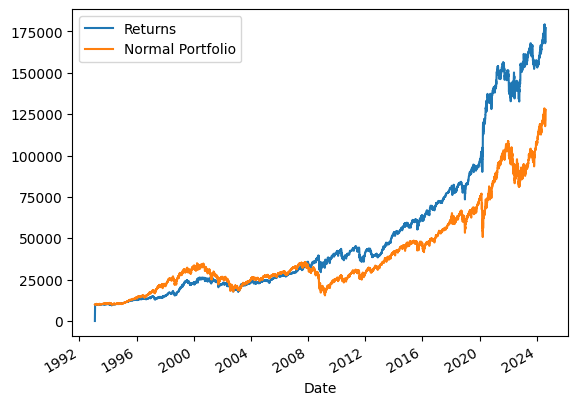

In [178]:
rf = 0.036

returns_normal = backtest_cci_df['Close'].iloc[-1] / backtest_cci_df['Close'].loc['1993-04-20'] - 1
print(f"Buy & Hold Returns: {returns_normal}")
normal_annualized_returns = returns_normal ** (1/t) - 1
print(f"Annualized Buy & Hold Returns:{normal_annualized_returns}")
normal_vol = backtest_cci_df['Close'].pct_change().std()
print(f"Buy & Hold Vol: {normal_vol}")
annualized_normal_vol = normal_vol * (t ** (1/2))
print(f"Annualized Buy & Hold Vol: {annualized_normal_vol}")
normal_sharpe = (normal_annualized_returns - rf)/annualized_normal_vol
print(f"Buy & Hold Sharpe Ratio: {normal_sharpe}")

print()

cci_returns = backtest_cci_df['Returns'].iloc[-1] / backtest_cci_df['Returns'].iloc[1] - 1
print(f"CCI Returns: {cci_returns}")
annualized_cci_returns = cci_returns ** (1/t) - 1
print(f"Annualized CCI Returns:{annualized_cci_returns}")
cci_vol = backtest_cci_df['Returns'].iloc[1:].pct_change().dropna().std()
print(f"CCI Vol: {cci_vol}")
annualized_cci_vol = cci_vol * ((t) ** (1/2))
print(f"Annualized CCI Vol: {annualized_cci_vol}")
cci_sharpe = (annualized_cci_returns - rf)/annualized_cci_vol
print(f"CCI Sharpe Ratio: {cci_sharpe}")

backtest_cci_df['Normal Position'] = 0
backtest_cci_df['Normal Portfolio'] = 0
backtest_cci_df['Normal Position'] = 10000/df['Close'].iloc[0]
backtest_cci_df['Normal Portfolio'] = backtest_cci_df['Normal Position'] *  df['Close']
backtest_cci_df[['Returns', 'Normal Portfolio']].plot()

In [171]:
n_sharpe = (0.08082246455747555 - .036) / 0.06615360168793614
cci_sharpe = (0.09343688893082192 - .0365) / 0.05098005383985089

print(n_sharpe, cci_sharpe)

0.6775513866790632 1.116846386817948


In [185]:
def backtest_adx(df, adx_period=14, trend_threshold=25):
    df_relevant = df[['Close', 'High', 'Low']].copy()

    # Calculate ADX
    df_relevant = calculate_adx(df_relevant, periods=adx_period)

    # Create buy and sell signals based on trend strength
    df_relevant['Buy_Signal'] = np.where(df_relevant['ADX'] > trend_threshold, 1, 0)  # Buy when ADX > trend threshold
    df_relevant['Sell_Signal'] = np.where(df_relevant['ADX'] < trend_threshold, -1, 0)  # Sell when ADX < trend threshold

    # Initialize positions and returns
    df_relevant['Position'] = 0
    df_relevant['Returns'] = 0.0
    initial_capital = 10000
    position = 0
    capital = initial_capital

    for i in range(1, len(df_relevant)):
        if df_relevant['Buy_Signal'].iloc[i] == 1 and position == 0:
            position = capital / df_relevant['Close'].iloc[i]  # Buy
            df_relevant['Position'].iloc[i] = position
            capital = 0
        elif df_relevant['Sell_Signal'].iloc[i] == -1 and position > 0:
            capital = position * df_relevant['Close'].iloc[i]  # Sell
            position = 0
            df_relevant['Position'].iloc[i] = 0

        df_relevant['Returns'].iloc[i] = (position * df_relevant['Close'].iloc[i]) + capital  # Calculate returns

    return df_relevant

# 100 Trials
#Best ADX Parameters: {'adx_period': 13, 'trend_threshold': 13.205912371567113}
#Best ADX Score: 183496.47985461727

backtest_adx_df = backtest_adx(df, adx_period=13, trend_threshold=13.205912371567113)

Streaming output truncated to the last 5000 lines.
<ipython-input-185-19d8f7e62b6d>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_relevant['Returns'].iloc[i] = (position * df_relevant['Close'].iloc[i]) + capital  # Calculate returns
<ipython-input-185-19d8f7e62b6d>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_relevant['Returns'].iloc[i] = (position * df_relevant['Close'].iloc[i]) + capital  # Calculate returns
<ipython-input-185-19d8f7e62b6d>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pand

2024-08-21 00:00:00 1993-03-08 00:00:00
t: 31.45516769336071
Buy & Hold Returns: 11.589361291228071
Annualized Buy & Hold Returns:0.08100527225118337
Buy & Hold Vol: 0.011782446969985897
Annualized Buy & Hold Vol: 0.0660817440037538
Buy & Hold Sharpe Ratio: 0.6810545473592046

ADX Returns: 17.349647985461726
Annualized ADX Returns:0.094960959712177
ADX Vol: 0.011561683760887679
Annualized ADX Vol: 0.06484359560332072
ADX Sharpe Ratio: 0.9092796160297678


<Axes: xlabel='Date'>

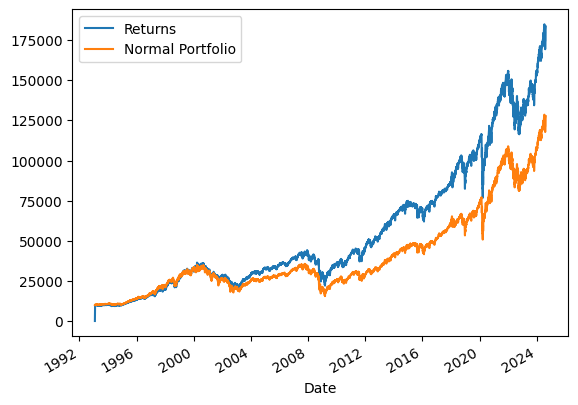

In [196]:
end_date = backtest_adx_df.index[-1]
start_date = (backtest_adx_df[backtest_adx_df['Buy_Signal'] == 1].index[0])
print(end_date, start_date)
t = difference_in_years(start_date, end_date)
print(f"t: {t}")

rf = 0.036

returns_normal = backtest_adx_df['Close'].iloc[-1] / backtest_adx_df['Close'].loc['1993-04-20'] - 1
print(f"Buy & Hold Returns: {returns_normal}")
normal_annualized_returns = returns_normal ** (1/t) - 1
print(f"Annualized Buy & Hold Returns:{normal_annualized_returns}")
normal_vol = backtest_adx_df['Close'].pct_change().std()
print(f"Buy & Hold Vol: {normal_vol}")
annualized_normal_vol = normal_vol * (t ** (1/2))
print(f"Annualized Buy & Hold Vol: {annualized_normal_vol}")
normal_sharpe = ((normal_annualized_returns) - rf)/annualized_normal_vol
print(f"Buy & Hold Sharpe Ratio: {normal_sharpe}")

print()

adx_returns = backtest_adx_df['Returns'].iloc[-1] / backtest_adx_df['Returns'].iloc[1] - 1
print(f"ADX Returns: {adx_returns}")
annualized_adx_returns = adx_returns ** (1/t) - 1
print(f"Annualized ADX Returns:{annualized_adx_returns}")
adx_vol = backtest_adx_df['Returns'].iloc[1:].pct_change().dropna().std()
print(f"ADX Vol: {adx_vol}")
annualized_adx_vol = adx_vol * ((t) ** (1/2))
print(f"Annualized ADX Vol: {annualized_adx_vol}")
adx_sharpe = ((annualized_adx_returns- rf))/annualized_adx_vol
print(f"ADX Sharpe Ratio: {adx_sharpe}")

backtest_adx_df['Normal Position'] = 0
backtest_adx_df['Normal Portfolio'] = 0
backtest_adx_df['Normal Position'] = 10000/df['Close'].iloc[0]
backtest_adx_df['Normal Portfolio'] = backtest_adx_df['Normal Position'] *  df['Close']
backtest_adx_df[['Returns', 'Normal Portfolio']].plot()

In [194]:
def backtest_momentum(df, momentum_period=14, momentum_threshold=0):
    df_relevant = df[['Close']].copy()

    # Calculate Momentum
    df_relevant = calculate_momentum(df_relevant, periods=momentum_period)

    # Create buy and sell signals
    df_relevant['Buy_Signal'] = np.where(df_relevant['Momentum'] > momentum_threshold, 1, 0)  # Buy on positive momentum
    df_relevant['Sell_Signal'] = np.where(df_relevant['Momentum'] < momentum_threshold, -1, 0)  # Sell on negative momentum

    # Initialize positions and returns
    df_relevant['Position'] = 0
    df_relevant['Returns'] = 0.0
    initial_capital = 10000
    position = 0
    capital = initial_capital

    for i in range(1, len(df_relevant)):
        if df_relevant['Buy_Signal'].iloc[i] == 1 and position == 0:
            position = capital / df_relevant['Close'].iloc[i]  # Buy
            df_relevant['Position'].iloc[i] = position
            capital = 0
        elif df_relevant['Sell_Signal'].iloc[i] == -1 and position > 0:
            capital = position * df_relevant['Close'].iloc[i]  # Sell
            position = 0
            df_relevant['Position'].iloc[i] = 0

        df_relevant['Returns'].iloc[i] = (position * df_relevant['Close'].iloc[i]) + capital  # Calculate returns

    return df_relevant

# 100 Trials
#Best Momentum Parameters: {'momentum_period': 13, 'momentum_threshold': 0.10816304251886813}
#Best Momentum Score: 56015.879867299365
backtest_momentum_df = backtest_momentum(df, momentum_period=13, momentum_threshold=0.10816304251886813)


Streaming output truncated to the last 5000 lines.
<ipython-input-194-5c97a71f6e91>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_relevant['Returns'].iloc[i] = (position * df_relevant['Close'].iloc[i]) + capital  # Calculate returns
<ipython-input-194-5c97a71f6e91>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_relevant['Returns'].iloc[i] = (position * df_relevant['Close'].iloc[i]) + capital  # Calculate returns
<ipython-input-194-5c97a71f6e91>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pand

2024-08-21 00:00:00 1993-03-02 00:00:00
t: 31.471594798083505
Buy & Hold Returns: 11.589361291228071
Annualized Buy & Hold Returns:0.08096132306307746
Buy & Hold Vol: 0.011782446969985897
Annualized Buy & Hold Vol: 0.0660989969723269
Buy & Hold Sharpe Ratio: 0.680211881004806

Momentum Returns: 4.601587986729936
Annualized Momentum Returns:0.049696342772199475
Momentum Vol: 0.006821742740828817
Annualized Momentum Vol: 0.038269669612828884
Momentum Sharpe Ratio: 0.3578902799727371


<Axes: xlabel='Date'>

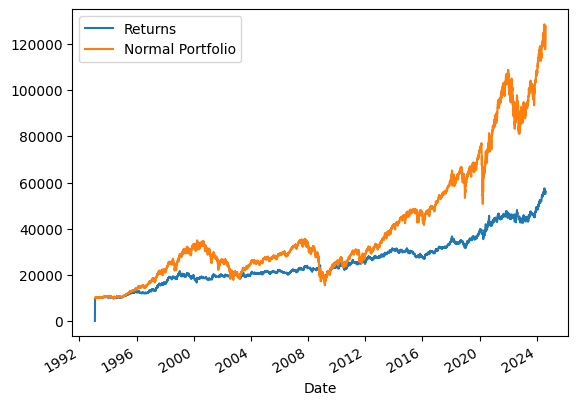

In [197]:
end_date = backtest_momentum_df.index[-1]
start_date = (backtest_momentum_df[backtest_momentum_df['Buy_Signal'] == 1].index[0])
print(end_date, start_date)
t = difference_in_years(start_date, end_date)
print(f"t: {t}")

rf = 0.036

returns_normal = backtest_momentum_df['Close'].iloc[-1] / backtest_momentum_df['Close'].loc['1993-04-20'] - 1
print(f"Buy & Hold Returns: {returns_normal}")
normal_annualized_returns = returns_normal ** (1/t) - 1
print(f"Annualized Buy & Hold Returns:{normal_annualized_returns}")
normal_vol = backtest_momentum_df['Close'].pct_change().std()
print(f"Buy & Hold Vol: {normal_vol}")
annualized_normal_vol = normal_vol * (t ** (1/2))
print(f"Annualized Buy & Hold Vol: {annualized_normal_vol}")
normal_sharpe = ((normal_annualized_returns) - rf)/annualized_normal_vol
print(f"Buy & Hold Sharpe Ratio: {normal_sharpe}")

print()

mtm_returns = backtest_momentum_df['Returns'].iloc[-1] / backtest_momentum_df['Returns'].iloc[1] - 1
print(f"Momentum Returns: {mtm_returns}")
annualized_mtm_returns = mtm_returns ** (1/t) - 1
print(f"Annualized Momentum Returns:{annualized_mtm_returns}")
mtm_vol = backtest_momentum_df['Returns'].iloc[1:].pct_change().dropna().std()
print(f"Momentum Vol: {mtm_vol}")
annualized_mtm_vol = mtm_vol * ((t) ** (1/2))
print(f"Annualized Momentum Vol: {annualized_mtm_vol}")
mtm_sharpe = ((annualized_mtm_returns- rf))/annualized_mtm_vol
print(f"Momentum Sharpe Ratio: {mtm_sharpe}")

backtest_momentum_df['Normal Position'] = 0
backtest_momentum_df['Normal Portfolio'] = 0
backtest_momentum_df['Normal Position'] = 10000/df['Close'].iloc[0]
backtest_momentum_df['Normal Portfolio'] = backtest_momentum_df['Normal Position'] *  df['Close']
backtest_momentum_df[['Returns', 'Normal Portfolio']].plot()

In [2]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
!pip install optuna
import optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.0 MB/s eta 0:00:00


In [ ]:
def objective_function(df, rsi_period, lower_threshold, upper_threshold):
    # Run backtest with current parameters
    df_backtested = backtest_rsi(df, rsi_period, lower_threshold, upper_threshold)

    # Calculate performance metric, e.g., total returns
    total_returns = df_backtested['Returns'].iloc[-1] - df_backtested['Returns'].iloc[0]

    return total_returns

def objective(trial):
    rsi_period = trial.suggest_int('rsi_period', 5, 100)
    lower_threshold = trial.suggest_uniform('lower_threshold', 0, 50)
    upper_threshold = trial.suggest_uniform('upper_threshold', 50, 100)

    # Ensure thresholds are consistent
    if lower_threshold >= upper_threshold:
        return float('inf')

    score = objective_function(df, rsi_period, lower_threshold, upper_threshold)
    return -score  # Optuna minimizes the objective function

# Create a study and optimize
study = optuna.create_study()
study.optimize(objective, n_trials=100)  # Number of trials

print(f"Best Parameters: {study.best_params}")
print(f"Best Score: {-study.best_value}")


Streaming output truncated to the last 5000 lines.
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_relevant['Returns'].iloc[i] = (position * df_relevant['Close'].iloc[i]) + capital  # Calculate returns
<ipython-input-9-4a009ee5d033>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_relevant['Returns'].iloc[i] = (position * df_relevant['Close'].iloc[i]) + capital  # Calculate returns
<ipython-input-9-4a009ee5d033>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-

Best Parameters: {'rsi_period': 13, 'lower_threshold': 32.7743057901687, 'upper_threshold': 98.27663744224036}
Best Score: 132983.54802892287


In [7]:
# Assuming calculate_macd and backtest_macd functions are defined

def objective_function_macd(df, short_period, long_period, signal_period):
    # Run backtest with current parameters
    df_backtested = backtest_macd(df, short_period, long_period, signal_period)

    # Calculate performance metric, e.g., total returns
    total_returns = df_backtested['Returns'].iloc[-1] - df_backtested['Returns'].iloc[0]
    return total_returns

def objective_macd(trial):
    short_period = trial.suggest_int('short_period', 5, 100)
    long_period = trial.suggest_int('long_period', 100, 200)
    signal_period = trial.suggest_int('signal_period', 5, 100)

    # Ensure consistency: short period < long period
    if short_period >= long_period:
        return float('inf')

    score = objective_function_macd(df, short_period, long_period, signal_period)
    return -score  # Optuna minimizes the objective function

# Create a study and optimize MACD parameters
study_macd = optuna.create_study()
study_macd.optimize(objective_macd, n_trials=200)

print(f"Best MACD Parameters: {study_macd.best_params}")
print(f"Best MACD Score: {-study_macd.best_value}")


Streaming output truncated to the last 5000 lines.
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_relevant['Returns'].iloc[i] = (position * df_relevant['Close'].iloc[i]) + capital  # Calculate returns
<ipython-input-12-39432a8e5128>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_relevant['Returns'].iloc[i] = (position * df_relevant['Close'].iloc[i]) + capital  # Calculate returns
<ipython-input-12-39432a8e5128>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

KeyboardInterrupt: 

In [164]:
# Assuming calculate_cci and backtest_cci functions are defined
def objective_function_cci(df, cci_period, overbought, oversold):
    # Run backtest with current parameters
    df_backtested = backtest_cci(df, cci_period, overbought, oversold)

    # Calculate performance metric, e.g., total returns
    total_returns = df_backtested['Returns'].iloc[-1] - df_backtested['Returns'].iloc[0]
    return total_returns

def objective_cci(trial, df):
    cci_period = trial.suggest_int('cci_period', 5, 50)
    overbought = trial.suggest_float('overbought', 100, 200)
    oversold = trial.suggest_float('oversold', -200, -100)

    score = objective_function_cci(df, cci_period, overbought, oversold)
    return -score  # Optuna minimizes the objective function

# Create a study and optimize CCI parameters
def optimize_cci(df):
    study_cci = optuna.create_study()
    study_cci.optimize(lambda trial: objective_cci(trial, df), n_trials=100)

    print(f"Best CCI Parameters: {study_cci.best_params}")
    print(f"Best CCI Score: {-study_cci.best_value}")

# Call the optimization function with your DataFrame
optimize_cci(df)  # Assuming df is your DataFrame containing the relevant data



Streaming output truncated to the last 5000 lines.
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_relevant['Returns'].iloc[i] = (position * df_relevant['Close'].iloc[i]) + capital
<ipython-input-153-98446adb0a05>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_relevant['Returns'].iloc[i] = (position * df_relevant['Close'].iloc[i]) + capital
<ipython-input-153-98446adb0a05>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_relevant['Returns'].iloc[i] 

Best CCI Parameters: {'cci_period': 10, 'overbought': 130.08471034934834, 'oversold': -110.75620776268163}
Best CCI Score: 177077.6273972904


In [184]:
# Assuming calculate_adx and backtest_adx functions are defined

def objective_function_adx(df, adx_period, trend_threshold):
    # Run backtest with current parameters
    df_backtested = backtest_adx(df, adx_period, trend_threshold)

    # Calculate performance metric, e.g., total returns
    total_returns = df_backtested['Returns'].iloc[-1] - df_backtested['Returns'].iloc[0]
    return total_returns

def objective_adx(trial):
    adx_period = trial.suggest_int('adx_period', 5, 50)
    trend_threshold = trial.suggest_uniform('trend_threshold', 10, 50)

    score = objective_function_adx(df, adx_period, trend_threshold)
    return -score  # Optuna minimizes the objective function

# Create a study and optimize ADX parameters
study_adx = optuna.create_study()
study_adx.optimize(objective_adx, n_trials=100)

print(f"Best ADX Parameters: {study_adx.best_params}")
print(f"Best ADX Score: {-study_adx.best_value}")


Streaming output truncated to the last 5000 lines.
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_relevant['Returns'].iloc[i] = (position * df_relevant['Close'].iloc[i]) + capital  # Calculate returns
<ipython-input-182-a4cb680c57d6>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_relevant['Returns'].iloc[i] = (position * df_relevant['Close'].iloc[i]) + capital  # Calculate returns
<ipython-input-182-a4cb680c57d6>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versu

Best ADX Parameters: {'adx_period': 13, 'trend_threshold': 13.205912371567113}
Best ADX Score: 183496.47985461727


In [191]:
# Assuming calculate_momentum and backtest_momentum functions are defined

def objective_function_momentum(df, momentum_period, momentum_threshold):
    # Run backtest with current parameters
    df_backtested = backtest_momentum(df, momentum_period, momentum_threshold)

    # Calculate performance metric, e.g., total returns
    total_returns = df_backtested['Returns'].iloc[-1] - df_backtested['Returns'].iloc[0]
    return total_returns

def objective_momentum(trial):
    momentum_period = trial.suggest_int('momentum_period', 5, 50)
    momentum_threshold = trial.suggest_uniform('momentum_threshold', 0.1, 2.0)

    score = objective_function_momentum(df, momentum_period, momentum_threshold)
    return -score  # Optuna minimizes the objective function

# Create a study and optimize Momentum parameters
study_momentum = optuna.create_study()
study_momentum.optimize(objective_momentum, n_trials=100)

print(f"Best Momentum Parameters: {study_momentum.best_params}")
print(f"Best Momentum Score: {-study_momentum.best_value}")


Streaming output truncated to the last 5000 lines.
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_relevant['Returns'].iloc[i] = (position * df_relevant['Close'].iloc[i]) + capital  # Calculate returns
<ipython-input-189-953ceac84a4f>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_relevant['Returns'].iloc[i] = (position * df_relevant['Close'].iloc[i]) + capital  # Calculate returns
<ipython-input-189-953ceac84a4f>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versu

Best Momentum Parameters: {'momentum_period': 13, 'momentum_threshold': 0.10816304251886813}
Best Momentum Score: 56015.879867299365


In [203]:
# Apply all the signals to the dataframe
# 100 Trials
#Best Parameters: {'rsi_period': 13, 'lower_threshold': 32.7743057901687, 'upper_threshold': 98.27663744224036}
#Best Score: 132983.54802892287

#Best MACD Parameters: {'short_period': 31, 'long_period': 179, 'signal_period': 6}
#Best MACD Score: 34688.872237147516

#Best CCI Parameters: {'cci_period': 10, 'overbought': 130.08471034934834, 'oversold': -110.75620776268163}
#Best CCI Score: 177077.6273972904

#Best ADX Parameters: {'adx_period': 13, 'trend_threshold': 13.205912371567113}
#Best ADX Score: 183496.47985461727

#Best Momentum Parameters: {'momentum_period': 13, 'momentum_threshold': 0.10816304251886813}
#Best Momentum Score: 56015.879867299365


df = calculate_rsi(df, 13)
df = calculate_adx(df, 13)
df = calculate_cci(df, 10)
df = calculate_macd(df, 31, 179, 6)
df = calculate_momentum(df, 13)

# Display the last few rows to check the signals
df[['Close', 'RSI', 'ADX', 'CCI', 'MACD', 'Signal_Line', 'Momentum']]

Close        RSI        ADX         CCI       MACD  \
Date                                                                  
1993-01-29   43.937500        NaN        NaN         NaN   0.000000   
1993-02-01   44.250000        NaN        NaN         NaN   0.016059   
1993-02-02   44.343750        NaN        NaN         NaN   0.035754   
1993-02-03   44.812500        NaN        NaN         NaN   0.078076   
1993-02-04   45.000000        NaN        NaN         NaN   0.126893   
...                ...        ...        ...         ...        ...   
2024-08-15  553.070007  54.739356  47.274527  165.436067  28.467984   
2024-08-16  554.309998  57.144507  42.002164  125.686750  28.841437   
2024-08-19  559.609985  55.324285  37.988331  119.488274  29.439990   
2024-08-20  558.700012  60.356429  34.389422  103.342732  29.927692   
2024-08-21  560.619995  70.515059  31.533086   85.340642  30.457715   

            Signal_Line   Momentum  
Date                                
1993-01-29     0.000000        NaN  
1993-02-01     0.004588        NaN  
1993-02-02     0.013493        NaN  
1993-02-03     0.031945        NaN  
1993-02-04     0.059073        NaN  
...                 ...        ...  
2024-08-15    29.196327   8.309997  
2024-08-16    29.094930  12.309998  
2024-08-19    29.193518   8.799987  
2024-08-20    29.403282  15.690002  
2024-08-21    29.704549  27.719971  

[7947 rows x 7 columns]

In [201]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Feature Engineering
df['RSI_Signal'] = np.where(df['RSI'] < 32.7743057901687, 1, np.where(df['RSI'] > 98.27663744224036, -1, 0))  # Buy=1, Sell=-1 # Alter RSI lower and upper parameter
df['Price_Change'] = df['Close'].pct_change().shift(-1)  # Predict next period price movement

# Prepare data for machine learning
X = df[['RSI', 'MACD', 'CCI', 'ADX', 'Momentum']].fillna(0)
y = np.where(df['Price_Change'] > 0, 1, 0)  # 1 for price increase, 0 for decrease

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Train a Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Test the model and evaluate performance
y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Model Accuracy: {accuracy * 100:.2f}%")

# Use this model to generate future signals for RSI optimization
df['Predicted_Signal'] = rf.predict(X)

Model Accuracy: 48.99%


In [212]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd

# Prepare data for online learning
X = df[['RSI', 'MACD', 'CCI', 'ADX', 'Momentum']].fillna(0)
y = np.where(df['Price_Change'] < 0, 1, 0)  # 1 for price increase, 0 for decrease

# Initialize an online learning classifier
sgd = SGDClassifier(loss="log_loss", learning_rate="optimal", random_state=42)

# Online learning: train and update model with each day's data
n_days = len(X)
accuracy_scores = []

# Ensure there is enough data to start training
min_samples = 10  # Start training after having at least this many samples

for i in range(min_samples, n_days):
    X_train = X.iloc[:i]  # Training data up to day i
    y_train = y[:i]        # Labels up to day i

    X_test = X.iloc[[i]]   # Test on day i+1
    y_test = y[i]          # Actual price movement on day i+1

    # Train the model on data so far
    sgd.partial_fit(X_train, y_train, classes=[0, 1])

    # Predict the next day
    y_pred = sgd.predict(X_test)

    # Evaluate accuracy of the prediction
    accuracy = accuracy_score([y_test], y_pred)
    accuracy_scores.append(accuracy)

# Average accuracy over the entire period
print(f"Average accuracy: {np.mean(accuracy_scores) * 100:.2f}%")





Average accuracy: 50.25%


DatetimeIndex(['1993-02-23', '1993-04-02', '1993-04-06', '1993-04-29',
               '1993-04-30', '1993-06-18', '1993-06-21', '1993-06-22',
               '1993-06-23', '1993-09-20',
               ...
               '2023-10-30', '2024-04-16', '2024-04-17', '2024-04-18',
               '2024-04-19', '2024-04-22', '2024-08-02', '2024-08-05',
               '2024-08-06', '2024-08-07'],
              dtype='datetime64[ns]', name='Date', length=711, freq=None)
DatetimeIndex(['2010-03-18'], dtype='datetime64[ns]', name='Date', freq=None)


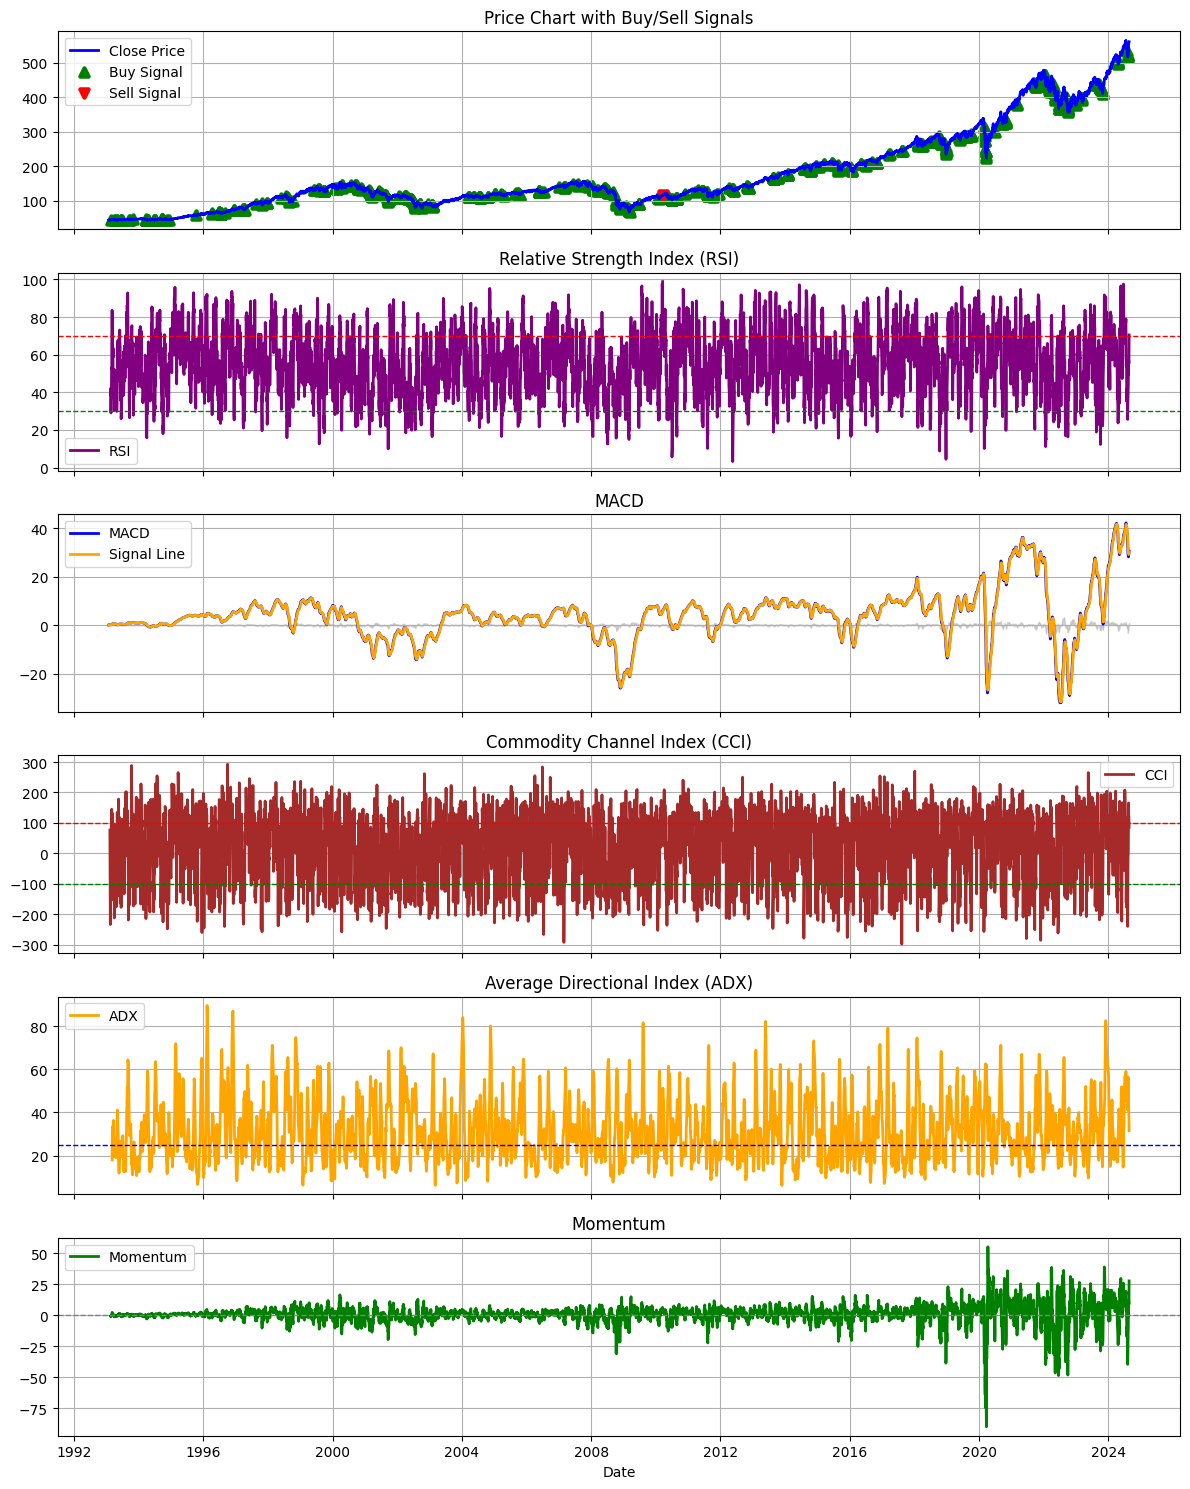

In [213]:
import matplotlib.pyplot as plt
import numpy as np


def plot_signals(df):
    # Generate buy and sell signals based on other indicators or strategies
    # This is just an example, replace with your actual signal generation logic
    df['Buy_Signal'] = np.where(df['RSI'] < 32.7743057901687, 1, 0)
    df['Sell_Signal'] = np.where(df['RSI'] > 98.27663744224036, -1, 0)

    print((df[df['Buy_Signal'] == 1].index))
    print((df[df['Sell_Signal'] == -1].index))

    fig, axs = plt.subplots(6, 1, figsize=(12, 15), sharex=True)

    # Price Chart with Buy and Sell Signals
    axs[0].plot(df.index, df['Close'], label='Close Price', color='blue', lw=2)
    axs[0].scatter(df.index[df['Buy_Signal'] == 1], df['Close'][df['Buy_Signal'] == 1], label='Buy Signal', marker='^', color='green', lw=3)
    axs[0].scatter(df.index[df['Sell_Signal'] == -1], df['Close'][df['Sell_Signal'] == -1], label='Sell Signal', marker='v', color='red', lw=3)
    axs[0].set_title('Price Chart with Buy/Sell Signals')
    axs[0].legend(loc='best')

    # RSI Plot
    axs[1].plot(df.index, df['RSI'], label='RSI', color='purple', lw=2)
    axs[1].axhline(y=30, color='green', linestyle='--', lw=1)
    axs[1].axhline(y=70, color='red', linestyle='--', lw=1)
    axs[1].set_title('Relative Strength Index (RSI)')

    # MACD Plot
    axs[2].plot(df.index, df['MACD'], label='MACD', color='blue', lw=2)
    axs[2].plot(df.index, df['Signal_Line'], label='Signal Line', color='orange', lw=2)
    axs[2].fill_between(df.index, df['MACD'] - df['Signal_Line'], color='gray', alpha=0.3)
    axs[2].set_title('MACD')

    # CCI Plot
    axs[3].plot(df.index, df['CCI'], label='CCI', color='brown', lw=2)
    axs[3].axhline(y=100, color='red', linestyle='--', lw=1)
    axs[3].axhline(y=-100, color='green', linestyle='--', lw=1)
    axs[3].set_title('Commodity Channel Index (CCI)')

    # ADX Plot
    axs[4].plot(df.index, df['ADX'], label='ADX', color='orange', lw=2)
    axs[4].axhline(y=25, color='blue', linestyle='--', lw=1)
    axs[4].set_title('Average Directional Index (ADX)')

    # Momentum Plot
    axs[5].plot(df.index, df['Momentum'], label='Momentum', color='green', lw=2)
    axs[5].axhline(y=0, color='gray', linestyle='--', lw=1)
    axs[5].set_title('Momentum')

    # Set common labels and layout
    for ax in axs:
        ax.legend(loc='best')
        ax.grid(True)

    plt.xlabel('Date')
    plt.tight_layout()
    plt.show()

# Call the function with your DataFrame containing signals and indicators
plot_signals(df)
